In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Clustering




**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from gap_statistic import OptimalK
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [4]:
# measure notebook runtime
time_start = time.time()


<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**Problem 1 [37.5 pts]: Clustering with k-means**](#part1)

- [**Problem 2 [37.5 pts]: Other Ks**](#part2)
  
- [**Problem 3 [25 pts]: DBSCAN**](#part3)


<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### The Dataset
In this assignment, you will be working with data collected from The Free Music Archive (https://freemusicarchive.org/). The Free Music Archive is an online repository of original music from independent artists that can be freely downloaded as an mp3. 

- the provided `fma_new.csv` contains 9,354 rows

- each music track is represented by a total of 82 summary audio features

- 8 interpretable features extracted by Echonest (now Spotify):\
`acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, `tempo`, `valence`

- 74 abstract audio features computated across the run time of the track using the [librosa](https://librosa.org/doc/latest/index.html) python package and then averaged. 

For those interested in more information about the FMA dataset please see the paper and GitHub repository (https://github.com/mdeff/fma)

<a id="part1"></a>

## <div class='exercise'>Part 1: Clustering with k-means </div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 Loading Data, Scaling, and KMeans Clustering</b></div>
    
1. **Load Data**: Read `data/fma_new.csv` into a DataFrame named `fma`.

2. **Standardize Data**: Standardize `fma` so all features in the dataset have a mean of 0 and a standard deviation of 1. Save the result in a DataFrame called `fma_scaled`, ensuring you have the exact same column names as `fma`.

3. **K-Means Clustering**: Run k-means clustering on `fma_scaled` with the following parameters:
   - Number of clusters (`n_clusters`): 12
   - Number of centroid initializations (`n_init`): 25
   - Random state (`random_state`): 109
     
4. **Save the fitted KMeans model as `km12`**


In [5]:
# your code here

# Load the data (1)
fma = pd.read_csv('data/fma_new.csv')

# Standardize the data (2)
scaler = StandardScaler()
fma_scaled = scaler.fit_transform(fma)
fma_scaled = pd.DataFrame(fma_scaled, columns=fma.columns)  # Retain original column names after scaling

# Run K-Means Clustering (3,4)
km12 = KMeans(n_clusters=12, n_init=25, random_state=109).fit(fma_scaled)

In [6]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Evaluating $k=12$</b></div>

<br>
The `silplot` function provided below creates two subplots: one displays the silhouette scores for each data point across all clusters and the other shows a projection of the data onto its first 2 principal components. In both subplots, the assigned cluster labels are encoded by color.

How reasonable does the clustering with $k=12$ appear? Use your understanding of the silhouette scores and information on the PCA projection plot to support your position.

In [7]:
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example we 
    # will set a lower limit on the x-axis to keep the plot small
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is {silhouette_avg}.")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # axes will be first 2 PCA components
    
    pca = PCA(n_components=2).fit(X.values)
    X_pca = pca.transform(X.values) 
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.35,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]    

    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1 ({}%)".format(np.round(100*pca.explained_variance_ratio_[0],1)))
    ax2.set_ylabel("PC2 ({}%)".format(np.round(100*pca.explained_variance_ratio_[1],1)))

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

_The clustering configuration represented in the provided plots suggests suboptimal partitioning of the data. The average silhouette score is close to 0.05, indicating minimal separation between clusters, as points in different clusters are not distinctly separated. This is visually corroborated by the PCA projection, which shows significant overlap between clusters and cluster centers that are closely positioned, implying poor cluster definition. The wide range of silhouette scores, with many close to zero or negative, further indicates that many data points may not belong distinctly to one cluster over another. Further, the silhouette plots for some clusters are also quite thin, indicating that those clusters contain relatively few points or that there is a lot of variation within the cluster._ 

_Overall, the clustering result appears to be reasonable in only a few areas, with a need for improvement in cluster definition and separation._

For n_clusters = 12, the average silhouette_score is 0.04952523346003029.


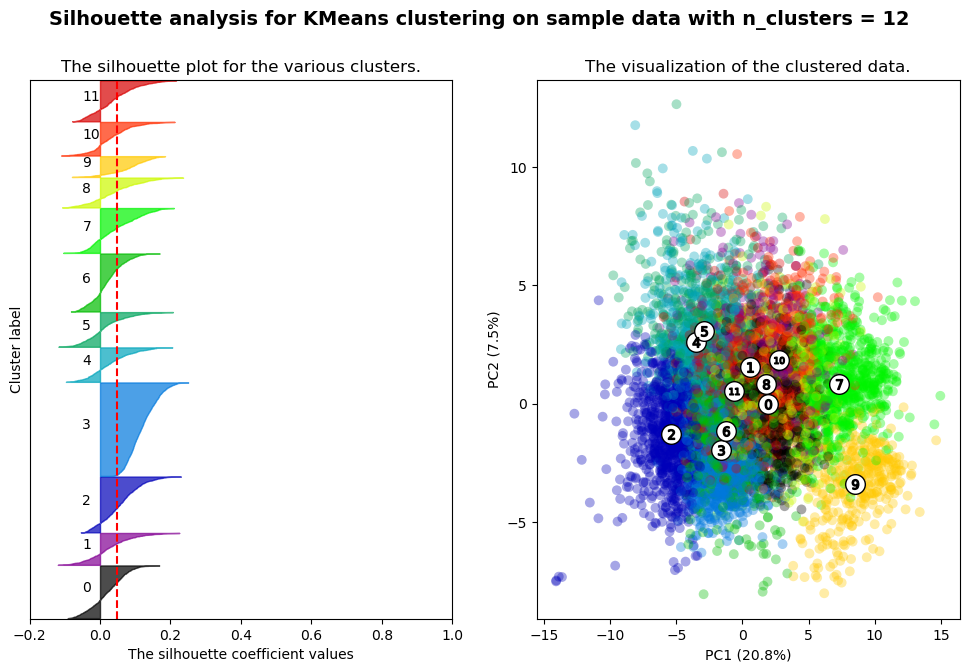

In [8]:
# your code here
cluster_labels = km12.predict(fma_scaled)
silplot(fma_scaled, cluster_labels, km12, pointlabels=None)

<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Part 2: Other Ks </div>

[Return to contents](#contents)

#### Overview
In Part 1, we naively assumed $k=12$ clusters based on distinct genres in the dataset. In part 2, you will explore varying cluster numbers using metrics to determine clustering effectiveness.

#### Data Sampling
- Work with a 2,000 data points sample.
- Use the Pandas `sample` method with `random_state=109`.
- Store in `processed_sample`.

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 Inertia</b></div>

Here you'll use the elbow method to evaluate the best choice of $k$, plotting the total inertia of each k-means clustering for $k \in \{1,2,...,15\}.$

Running `KMeans` across many values of $k$ can take a long time so we'll take a few steps to speed things up.

First, you should only be clustering a subset of the scaled data in this section (part 2). Using the DataFrame's `sample` method with a `random_state` of 109, sample 2,000 data points and store them in `processed_sample`.

Next, when fitting each KMeans object, use only 10 initializations and a random state of 109 as before.

Finally, create a well-labeled plot of inertia as a function of $k$ and describe what value(s) of $k$ might be considered optimal with respect to this plot and why.

_The elbow plot indicates that the inertia, or within-cluster sum of squares, sharply declines as the number of clusters increases from 1 to 4, suggesting that 4 or 5 clusters appears to be the optimal number for this dataset. This is because, beyond 4 clusters, the inertia's decline is less pronounced, signifying a smaller benefit in model accuracy relative to the increased model complexity that additional clusters would bring._

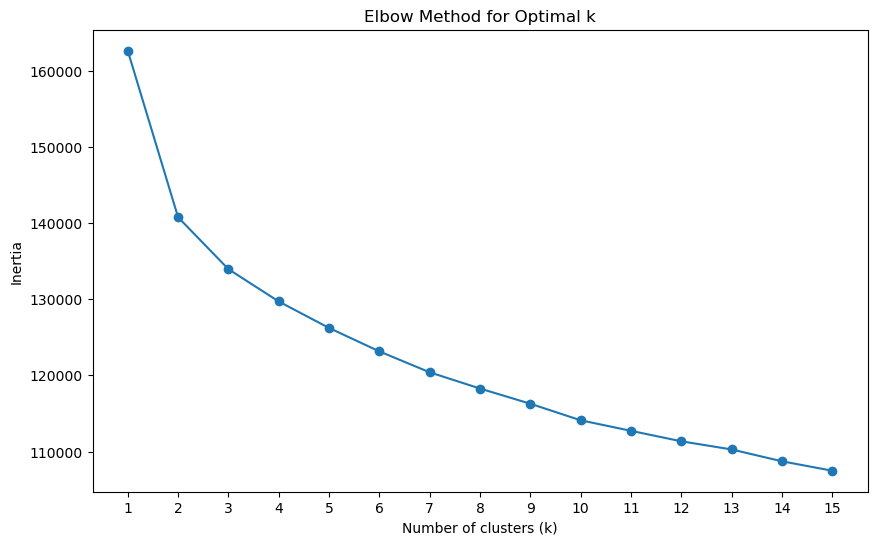

In [9]:
# your code here
processed_sample = fma_scaled.sample(n=2000, random_state=109)
inertias = []
k_values = range(1, 16) 


kmeans_models = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=109)
    kmeans.fit(processed_sample)
    kmeans_models.append(kmeans) 
    inertias.append(kmeans.inertia_) 
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

In [10]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 Silhouette Score</b></div>

Using the labels from each of the 15 fitted KMeans objects in the previous question, calculate the average silhouette scores and store them in `sil_scores`. 

Plot the average silhouette scores in `sil_scores` as a function of $k$. Describe what value(s) of $k$ might be considered optimal with respect to this plot and why.

**Hints:**
* If you stored your results from Q2.1 you shouldn't have to refit any KMeans objects here
* `silhouette_score` will throw an error if you try and score labels containing only a single cluster. Note that the silhouette score when $k=1$ is defined to be 0.

_The silhouette plot below makes a strong case for k = 2 as the silhouette score sees a sharp increase for 2 and is subsequently much lower for remaining k values. The lower values for the remaining values of k suggests that this algorithm has identified two main clusters within this dataset (different from the elbow plot)._

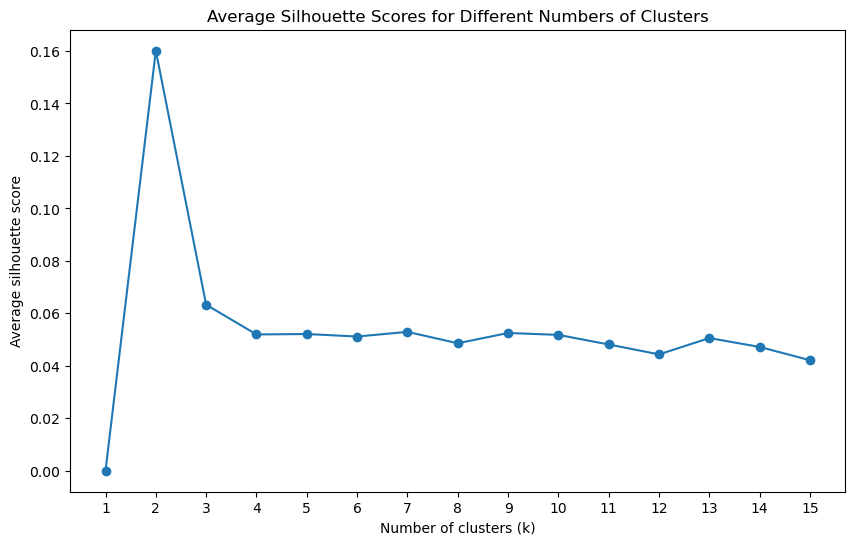

In [11]:
# your code here
sil_scores = [0]  

for kmeans in kmeans_models[1:]:  
    labels = kmeans.predict(processed_sample)
    sil_score = silhouette_score(processed_sample, labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), sil_scores, marker='o')  
plt.title('Average Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette score')
plt.xticks(range(1, 16)) 
plt.show()

In [12]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 Gap Statistic</b></div>

Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Again, use `processed_sample` rather than the entire dataset to save time. 

Create a well-labeled plot showing the gap statistic as a function of the number of clusters.

Describe the rule for picking the optimum number of clusters described in [the original gap statistic paper](https://hastie.su.domains/Papers/gap.pdf). This is the method referred to in lab as the "slack" rule. You'll need to use $\LaTeX$ in a markdown cell to communicate this clearly.

Finally, demonstrate which value of $k$ is suggested by your results when using this "slack" rule. 

**Note:** You may attempt to implement the the gap statistic yourself or use the package demonstrated in lab. Just be aware that the package has [difficulties with reproducibility](https://github.com/milesgranger/gap_statistic/issues/59) so don't worry if your results change across runs. Setting a random seed with numpy and setting OptimalK's `n_jobs=1` helps, but it makes everything run unbearably slow. 

**Hint:** The [gap_statistic GitHub repo](https://github.com/milesgranger/gap_statistic) is a good place to find information about the `OptimalK` object and its attributes.

_The gap statistic, proposed by Tibshirani, Walther, and Hastie (2001), provides a method for choosing the optimal number of clusters k for a dataset. The key steps are:_

- _Compute the gap statistic Gap_n(k) for a range of $k$ values. This measures the difference between the logarithm of the within-cluster dispersion W_k and its expected value under a null reference distribution._

- _Estimate the standard error $s_k$ of the gap statistic using multiple reference datasets. This captures the sampling variability._

- _Select the smallest k such that:_
   $$ \text{Gap}(k) \geq \text{Gap}(k+1) - s_{k+1} $$

_This "slack" criterion ensures that the choice of $k$ is not just variability._

_Formally, the rule is: $$k^* = \min\{k | \text{Gap}(k) \geq \text{Gap}(k+1) - s_{k+1}\}$$ where k* is the optimal number of clusters._

_The idea is to choose the smallest k that captures the clustering structure in the data, balancing between within-cluster compactness and avoiding trying to fit additional clusters that may just reflect noise or sampling fluctuations._

15


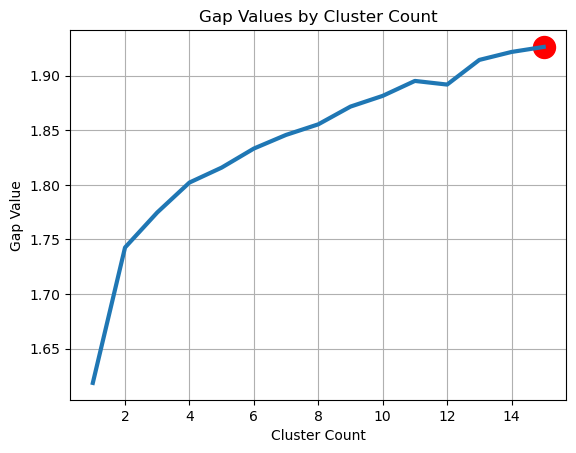

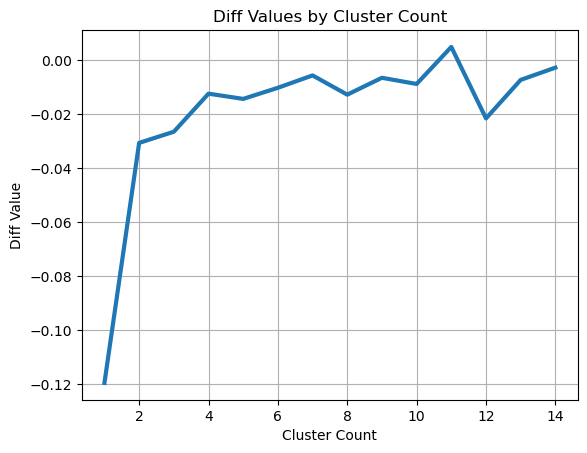

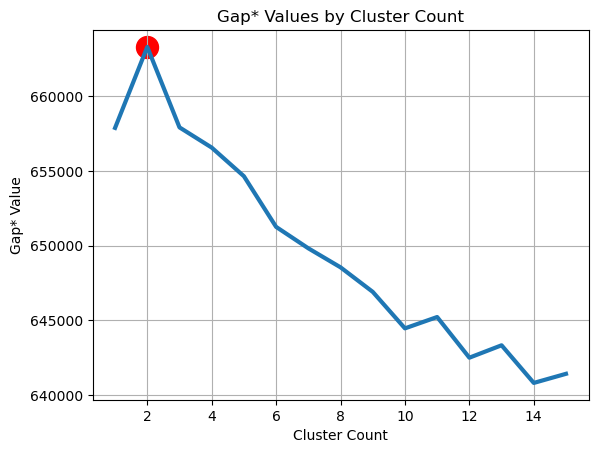

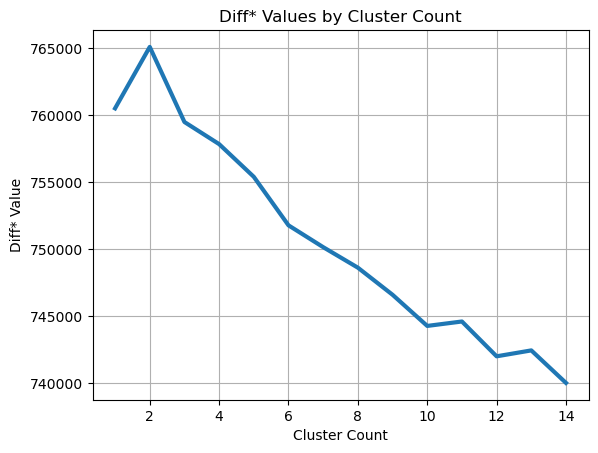

In [13]:
# your code here
np.random.seed(109)  # Set the seed for reproducibility


optimalK = OptimalK(n_jobs=1, parallel_backend='joblib')
n_clusters = optimalK(processed_sample.to_numpy(), cluster_array=np.arange(1, 16))
gap_values = optimalK.gap_df['gap_value']
print(n_clusters)

#plt.figure(figsize=(10, 6))
#plt.plot(range(1, 16), gap_values, marker='o')
#plt.title('Gap Statistic as a Function of k')
#plt.xlabel('Number of clusters (k)')
#plt.ylabel('Gap Statistic')
#plt.xticks(range(1, 16))
#plt.show()

optimalK.plot_results()

In [14]:
optimalK.gap_df
slackk = optimalK.gap_df[optimalK.gap_df['diff'] >= 0].iloc[0].n_clusters
maxk = optimalK.gap_df['gap*'].argmax()+1

In [15]:
print(slackk)
print(maxk)

11.0
2


The OptimalK metric, slack rule diff column, and maximum adjusted gap value provide conflicting suggestions for the ideal number of clusters k in this dataset - 14, 11, and 2 respectively. Ultimately, the choice depends on the context and intended use. A small k like 2 implies a dominant separation into broad categories. In contrast, larger values of 10-14 suggest nuanced sub-groupings exist. If the goal is to uncover subtle and granular structure, orienting towards solutions on the higher end makes sense. However, if broad trends are adequate or even preferred for simpler interpretation, then lower values may suffice. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 Choose a Best $k$</b></div>

After analyzing the plots produced by all three of these metrics, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the three graphs produced here and what you surmise about this dataset. Store your choice in `best_k`.

_The optimal number of clusters is unclear based on the different methods - the elbow plot plateaus around 4-5, silhouette scoring peaks at 2, and the gap statistic suggests 14 initially then 11 per the slack rule (with 2 as best from the adjusted metric). Given this, there are a few considerations. If simplicity is preferred, lower values near 2 make sense, as the silhouette score shows reasonably distinct separation. However, if more granularity is needed to capture nuanced structure, higher values like 10-11 balance intra-cluster cohesion with splitting the data. Ultimately the context and intended application should drive the choice. In this case, since k=2 provides the highest silhouette score by a significant margin and gives interpretable groupings, it strikes the right balance of discernible clustering without overcomplicating the analysis. For these reasons, k = 2 clusters are optimal for this dataset based on the evidence and goals._

In [16]:
# your code here
best_k = 2

In [17]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.5 Visualize & Interpret Best $k$ Results</b></div>

Fit KMeans on the *entire scaled dataset* using your choice of `best_k`, 25 initializations, and a random state of 109. Store the KMeans object in `km_best` and the resulting labels in `km_labels`. 

Next, use `silplot` to visualize these clusters and their silhouette scores. 

How do these plots differ from the previous pair, and what might that mean about the clusterings? Would you consider your kmeans clustering with `best_k` successful?

_The silhouette and PCA plot for k = 2 clusters is quite different from the earlier plot for k = 12 clusters. While the silhouette score has increased a fair bit, I am not fully sure I would consider this result to be fully successful. k = 2 has captures some significant distinction between the two clusters as can be seen, but the silhouette scores for cluster 0 has a big range, with many of points below the average line. In other words, this could beindicative of some overlap._

For n_clusters = 2, the average silhouette_score is 0.16569139147003403.


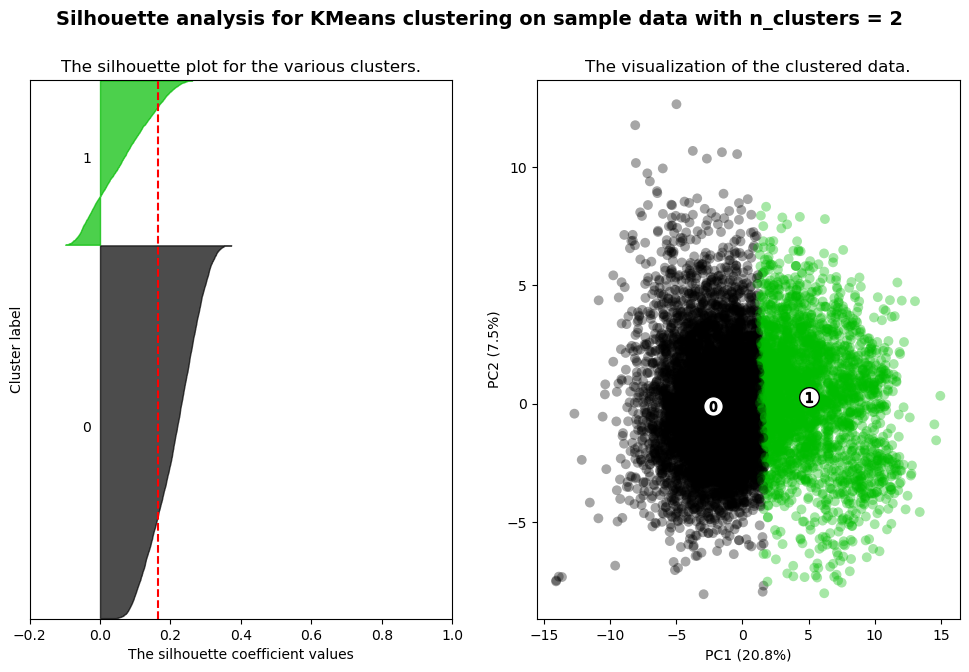

In [18]:
# your code here
km_best = KMeans(n_clusters=best_k, n_init=25, random_state=109)
km_labels = km_best.fit_predict(fma_scaled)

silplot(fma_scaled, km_labels, km_best, pointlabels=None)

In [19]:
grader.check("q2.5")

q2.5 results: All test cases passed!

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Part 3: DBSCAN </div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1: DBSCAN</b></div>

Create a well-labeled knee plot to determine an optimal epsilon for when the min point parameter is 5. Then run DBSCAN on the data using your choice of `episilon` and the speficied `min_samples=5`.

Store all labels produced in `dbscan_labels`.\
Store the number of *clusters* found by the algorithm in `dbscan_n_clusters`.

Inspect the number of points that were assigned to each *label*. What does this tell you about the clusters and give a geometric interpretation of what kind of data might lead to this result of DBSCAN?

_Upon playing with different values of epsilon and n_clusters, the DBSCAN output shows one highly dominant cluster containing ~7500 points, several very small clusters with only fewer than 10 points each, and a sizable set of ~1700 noise points not assigned to any cluster. This suggests the data forms one primary dense cluster representing the majority pattern, plus some small fringes that are quite distinct from the main group. The large share of unclustered noise indicates a significant portion does not fit well into the primary density-based structure captured for the chosen ε value of 11, which may require additional tuning. Overall, the prominent singular cluster aligns with the best k=2 outcome from earlier methods, implying the data can be partitioned into one majority cluster and smaller ancillary groups plus outliers. However, the prevalence of noise and small clusters indicates complexities that basic DBSCAN does not fully model._

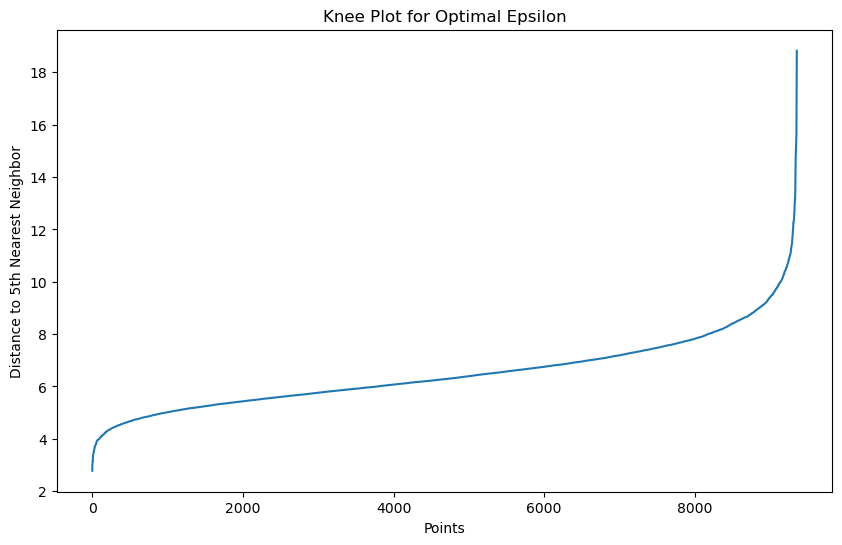

In [20]:
# your code here

min_samples = 5
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors = nearest_neighbors.fit(fma_scaled)
distances, indices = neighbors.kneighbors(fma_scaled)

sorted_distances = np.sort(distances[:, min_samples-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('Knee Plot for Optimal Epsilon')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.show()

In [21]:
epsilon = 11
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(fma_scaled)

dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

In [22]:
dbscan_n_clusters

1

In [23]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2</b></div>

Load `data/track_info.csv` into the Dataframe `track_info` and inspect it. This track info corresponds to the data in `fma` row-for-row.

Create a well-labeled plot or set of subplots that visualize the 'top genre' make-up of each cluster designated by the two sets of labels: `km_labels` and `dbscan_labels`.

What does your visualization demonstrate about how each clustering compares to the genre labels? Does one clustering seem more successful at capturing genre distinctions?

**Hint:** There are many ways you could approach this visualization task. Experiment! You may also find it helpful to create plotting functions to handle some parts of the visualization if they are being repeated with slightly different parameters (e.g., cluster labels).

_KMeans appears to be more successful than DBSCAN at separating out the genres based on this visualization. The KMeans clustering shows a more balanced distribution of genres across the two clusters, suggesting that it is able to distinguish between genres without overly favoring one over another. In contrast, the DBSCAN clustering results in one cluster being heavily dominated by a single genre, while the other cluster is labeled as noise (indicated by -1), suggesting that DBSCAN either found the data too noisy or the parameters were not set optimally for genre separation. Therefore, KMeans seems to provide a clearer and more distinct separation of musical genres into clusters as per the stated goal._

  artist_name   track_title track_genre_top track_genres_all
0        AWOL          Food         Hip-Hop      ['Hip-Hop']
1        AWOL  Electric Ave         Hip-Hop      ['Hip-Hop']
2        AWOL    This World         Hip-Hop      ['Hip-Hop']
3   Kurt Vile       Freeway             Pop          ['Pop']
4        AWOL  Street Music         Hip-Hop      ['Hip-Hop']


<Figure size 1000x600 with 0 Axes>

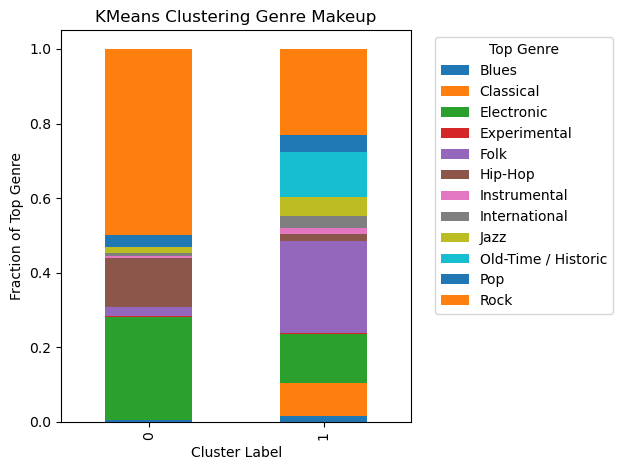

<Figure size 1000x600 with 0 Axes>

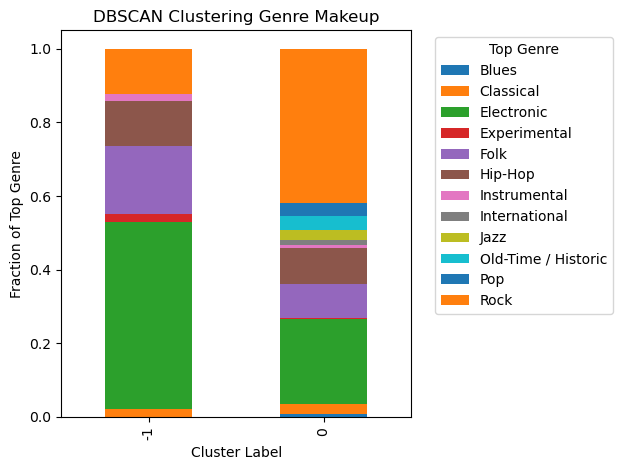

In [24]:
# your code here
track_info = pd.read_csv('data/track_info.csv')
print(track_info.head())

track_info['km_labels'] = km_labels
track_info['dbscan_labels'] = dbscan_labels

#track_info.groupby('dbscan_labels')['track_genre_top'].value_counts()


def plot_genre_makeup(df, labels_column, title):
    plt.figure(figsize=(10, 6))
    genre_counts = df.groupby(labels_column)['track_genre_top'].value_counts(normalize=True).unstack().fillna(0)
    genre_counts.plot(kind='bar', stacked=True)
    plt.title(title)
    plt.xlabel('Cluster Label')
    plt.ylabel('Fraction of Top Genre')
    plt.legend(title='Top Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plot_genre_makeup(track_info, 'km_labels', 'KMeans Clustering Genre Makeup')

plot_genre_makeup(track_info, 'dbscan_labels', 'DBSCAN Clustering Genre Makeup')

plt.show()

<!-- END QUESTION -->

<a id="bonus"></a>

## <div class='exercise'>Wrap-up</div>

[Return to contents](#contents)

The only required section here is to report the amount of time you spent on this assignment.

You are encouraged to use this space to continue to explore the fma dataset. You could:
- Try different clustering methods (e.g., total linkage)
- Attempt feature selection, engineering, or dimentionality reduction before clustering
- Sample points from clusters and inspect their track information to get an idea what a cluster might represent
- Find the nearest neighbors in the feature space to a track of interest
- Pull in new data from the [FMA project](https://github.com/mdeff/fma). There are thousands of additional tracks to use (these were just the only ones that also had the Spotify features and track info available). And there are also hundreds of additional (abstract) audio feature columns that can be used.

How many hours did you spend working on this assignment?

In [25]:
time_spent_on_hw = 4

In [26]:
# your additional (optional) code here
...

In [27]:
grader.check("wrap-up")

wrap-up results: All test cases passed!

In [28]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 0.47 minutes for this notebook to run


🌈 **This concludes HW1. Thank you!**